In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import forecast

In [12]:
sns.set_context('notebook') 
sns.set_style('ticks')
red = '#D62728'
blue = '#1F77B4'
%matplotlib inline

plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 16})

# EDA

In [3]:
visitors = pd.read_csv('Visitors.csv', index_col='Date', parse_dates=['Date'])
visitors.index = pd.to_datetime(visitors.index, format='%b-%y')

In [4]:
y = visitors['Number of Visitors'].copy()
y.index = y.index.to_period(freq='M')

ts = visitors['Number of Visitors']

In [37]:
visitors.describe().round(4).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Number of Visitors</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>count</th>\n      <td>312.0000</td>\n    </tr>\n    <tr>\n      <th>mean</th>\n      <td>419407.3718</td>\n    </tr>\n    <tr>\n      <th>std</th>\n      <td>132443.0593</td>\n    </tr>\n    <tr>\n      <th>min</th>\n      <td>161400.0000</td>\n    </tr>\n    <tr>\n      <th>25%</th>\n      <td>332625.0000</td>\n    </tr>\n    <tr>\n      <th>50%</th>\n      <td>412950.0000</td>\n    </tr>\n    <tr>\n      <th>75%</th>\n      <td>488775.0000</td>\n    </tr>\n    <tr>\n      <th>max</th>\n      <td>971800.0000</td>\n    </tr>\n  </tbody>\n</table>'

In [13]:
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative', period=12)
decomposition.seasadj = decomposition.seasonal
decomposition.irregular = decomposition.resid

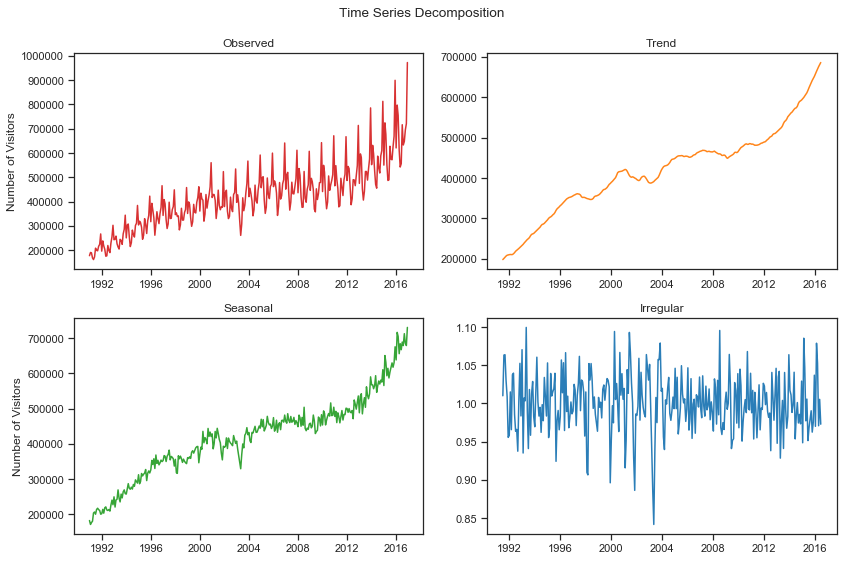

In [14]:
forecast.plot_components_x13(decomposition, 'Number of Visitors')
plt.show()

# Modelling (MHW)

## Methodology

In [7]:
model1 = forecast.holtwinters(ts, additive=False, damped=False, m=12)
model1.fit()
model1.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.310 (0.078)
 beta  (trend)    0.012 (0.009)
 delta (seasonal) 0.362 (0.050)
 
 In-sample fit:
 MSE               434674463.731
 RMSE              20848.848
 Log-likelihood   -3545.566
 AIC               7099.131
 BIC               7114.103


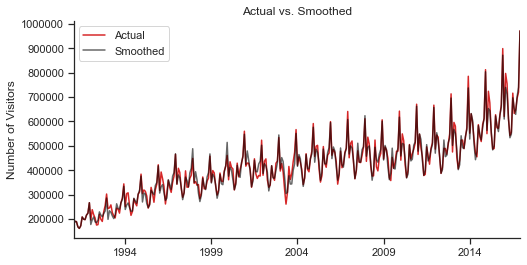

In [15]:
smoothed = pd.Series(model1.smooth(), index=ts.index)

fig, ax = plt.subplots(figsize=(8,4))
ts.plot(color='#D62728', label='Actual')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.legend(loc='upper left')
plt.ylabel('Number of Visitors')
plt.title('Actual vs. Smoothed')

sns.despine()
plt.show()

## Model Diagnostics

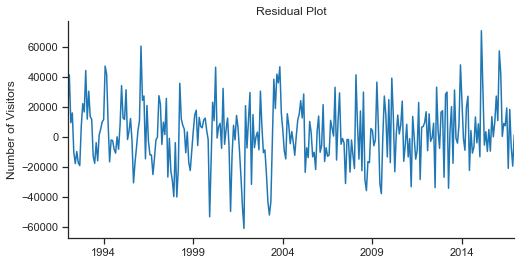

In [16]:
model_residuals = (ts - model1.smooth())[12:]

fig, ax = plt.subplots(figsize=(8,4))
model_residuals.plot(color=blue)
ax.set_title('Residual Plot')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
sns.despine()
plt.ylabel('Number of Visitors')
plt.show()

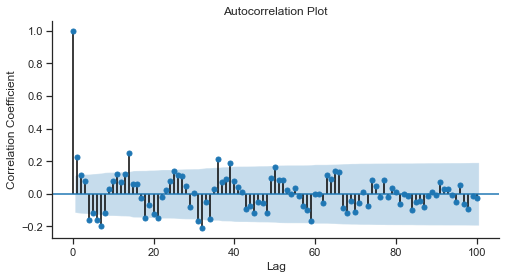

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
sm.graphics.tsa.plot_acf(model_residuals, lags=100, ax=ax)
sns.despine()
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.title('Autocorrelation Plot')
plt.show()

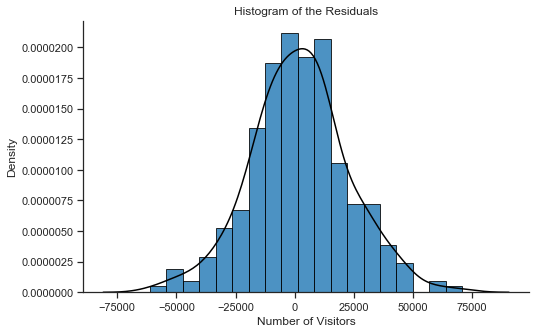

In [22]:
forecast.histogram(model_residuals)
plt.title('Histogram of the Residuals')
plt.show()

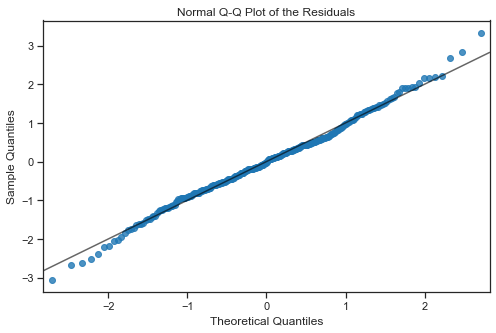

In [23]:
forecast.qq_plot(model_residuals)
plt.title('Normal Q-Q Plot of the Residuals')
plt.show()

# Modelling (MHW with damping)

## Methodology

In [25]:
model = forecast.holtwinters(ts, additive=False, damped=True, m=12)
model.fit()
model.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.482 (0.077)
 beta  (trend)    0.000 (0.029)
 delta (seasonal) 0.412 (0.086)
 phi (damping)    0.792 (0.054)
 
 In-sample fit:
 MSE               445818494.913
 RMSE              21114.414
 Log-likelihood   -3549.515
 AIC               7109.029
 BIC               7127.744


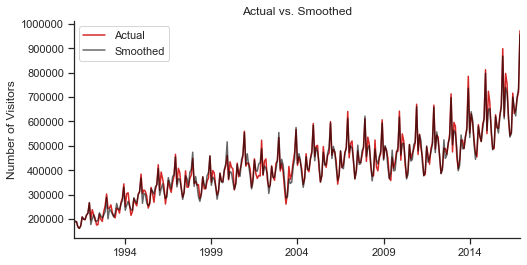

In [26]:
smoothed = pd.Series(model.smooth(), index=ts.index)

fig, ax = plt.subplots(figsize=(8,4))
ts.plot(color='#D62728', label='Actual')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.legend(loc='upper left')
plt.ylabel('Number of Visitors')
plt.title('Actual vs. Smoothed')

sns.despine()
plt.show()

## Model Diagnostics

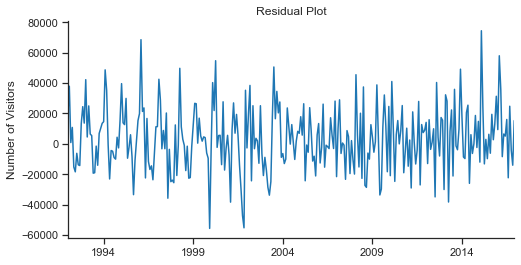

In [27]:
model_residuals = (ts - model.smooth())[12:]

fig, ax = plt.subplots(figsize=(8,4))
model_residuals.plot(color=blue)
ax.set_title('Residual Plot')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.ylabel('Number of Visitors')
sns.despine()
plt.show()

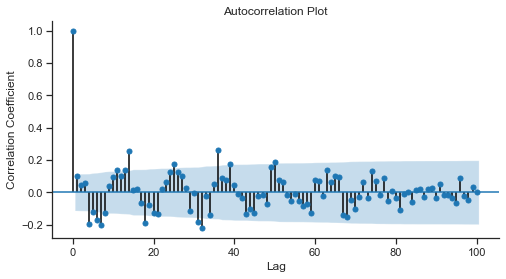

In [28]:
fig, ax = plt.subplots(figsize=(8,4))
sm.graphics.tsa.plot_acf(model_residuals, lags=100, ax=ax)
sns.despine()
plt.title('Autocorrelation Plot')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag')
plt.show()

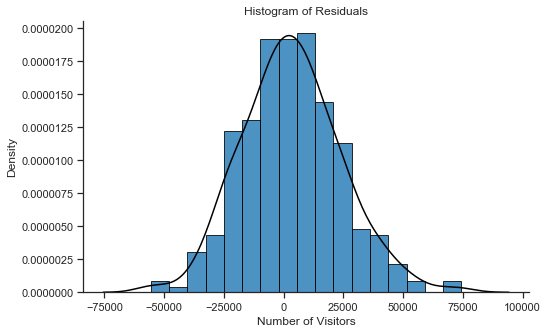

In [29]:
forecast.histogram(model_residuals)
plt.title('Histogram of Residuals')
plt.show()

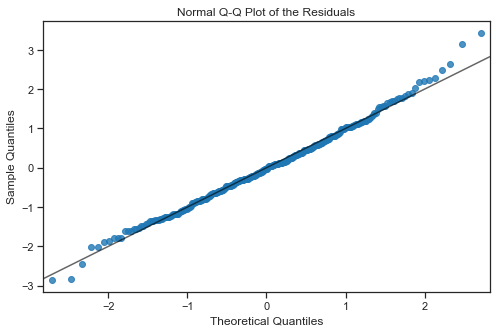

In [30]:
forecast.qq_plot(model_residuals)
plt.title('Normal Q-Q Plot of the Residuals')
plt.show()

# Results

## Model Validation

In [40]:
start = ts.index.get_loc('2010-01-01') 

pred1 = []
pred = []
actual = []

for i in range(start, len(ts)):
    
    model_train1 = forecast.holtwinters(ts.iloc[:i], additive=False, damped=False, m=12)
    model_train1.fit()
    model_train = forecast.holtwinters(ts.iloc[:i], additive=False, damped=True, m=12)
    model_train.fit()
    
    actual.append(ts.iloc[i])
    pred1.append(model_train1.forecast(1)[0])
    pred.append(model_train.forecast(1)[0])
    
columns=['MHW', 'MHW with damping', 'Actual']
results = np.vstack([pred1, pred, actual]).T
results = pd.DataFrame(results, columns=columns, index=ts['2010-01-01':].index)

In [43]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
table.iloc[0, 0], table.iloc[0, 1] = rmse_jack(results.iloc[:, -1], results.iloc[:,0])
table.iloc[1, 0], table.iloc[1, 1] = rmse_jack(results.iloc[:, -1], results.iloc[:,1])
table.round(4).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>RMSE</th>\n      <th>SE</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>MHW</th>\n      <td>23485.9423</td>\n      <td>2702.3208</td>\n    </tr>\n    <tr>\n      <th>MHW with damping</th>\n      <td>24322.3280</td>\n      <td>2724.1950</td>\n    </tr>\n  </tbody>\n</table>'

## Forecasting

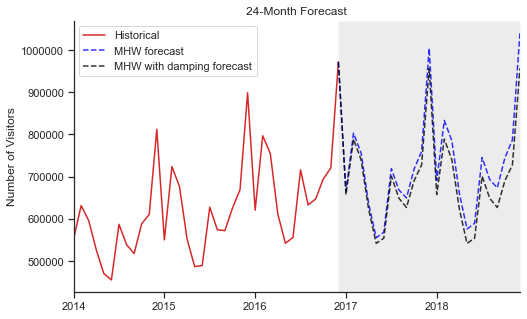

In [31]:
h = 24

test = pd.period_range(start=y.index[-1]+1, periods=h, freq='M')
pred = pd.Series(model.forecast(h), index=test)
pred1 = pd.Series(model1.forecast(h), index=test)

last = y['2014-01-01':].iloc[-1:]
extended = last.append(pred)
extended1 = last.append(pred1)

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8,5))
    y['2014-01-01':].plot(color='#D62728', label='Historical')
    extended1.plot(color='blue', linestyle='--', alpha=0.8, label='MHW forecast')
    extended.plot(color='black', linestyle='--', alpha=0.8, label='MHW with damping forecast')
    hold = ax.get_ylim()
    ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
    ax.set_ylim(hold)
    
plt.legend(loc='upper left')
plt.ylabel('Number of Visitors')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('24-Month Forecast')
    
sns.despine()
plt.show()

In [83]:
pd.DataFrame({'Predictions': pred1}).round(3)
pd.DataFrame({'Predictions': pred}).round(3)

,Predictions
2017-01,657431.641
2017-02,788987.211
2017-03,739766.390
2017-04,622299.631
2017-05,541747.994
2017-06,553858.787
2017-07,700859.648
2017-08,648617.908
2017-09,626761.710
2017-10,689977.220
